In [1]:
from IPython.core.display import HTML

%matplotlib inline
from matplotlib import style
style.use('ggplot')

This post is a quick note on how to convert to and from UTM coordinates using
[pyproj](pyproj).

As the end of the year approaches my TODO list gets bigger and bigger and my
posts get smaller and smaller...  Well, this one is small but I find it useful.
I always need to check how to do this every I need to convert to/from UTM
coordinates.

`pyproj` is used under the hood of several python packages like basemap,
cartopy, pyresample.  So, if you have any of one those above installed, you
probably already have `pyproj` as well.

In [2]:
from pyproj import Proj

Here is am example from real life case that I had to deal recently.  Someone
gave me the corners of a map in UTM but the sampling site positions as lon,
lat collected in WGS84.  Here are the data:

In [3]:
import numpy as np
from pandas import DataFrame

core = (-44.6360, -23.2278)

print('\nSampling site lon %s, lat %s\n' % (core[0], core[1]))

x = (529025.00, 529114.00, 545227.00, 545582.00)
y = (7422210.00, 7422343.00, 7435702.00, 7435741.00)

df = DataFrame(np.c_[x, y], columns=['Meters East', 'Meters South'])
df


Sampling site lon -44.636, lat -23.2278



,Meters East,Meters South
0,529025.0,7422210.0
1,529114.0,7422343.0
2,545227.0,7435702.0
3,545582.0,7435741.0


All that is needed to solve that problem is a `pyproj` object for Zone 23K
(near Paraty-Brazil) using `Datum WGS-84`.  Note that we need to specify that
we are in the South Hemisphere.

In [14]:
myProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

The next cell uses the object created (`myProj`) to convert the UTM positions
to longitude and latitude.  That is why we need the *inverse* keyword.

In [5]:
lon, lat = myProj(df['Meters East'].values, df['Meters South'].values, inverse=True)

To convert back just from comparison:

In [6]:
UTMx, UTMy = myProj(lon, lat)

And now a quick table to show the results in the notebook,

In [7]:
DataFrame(np.c_[UTMx, UTMy, lon, lat], columns=['UTMx', 'UTMy', 'Lon', 'Lat'])

,UTMx,UTMy,Lon,Lat
0,529025.0,7422210.0,-44.716128,-23.309315
1,529114.0,7422343.0,-44.715260,-23.308112
2,545227.0,7435702.0,-44.558073,-23.187077
3,545582.0,7435741.0,-44.554606,-23.186714


Now I can make a map to show the sampling site.

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftdata
method to adjust the data to be consistent with the map projection
region (see examples/shiftdata.py).

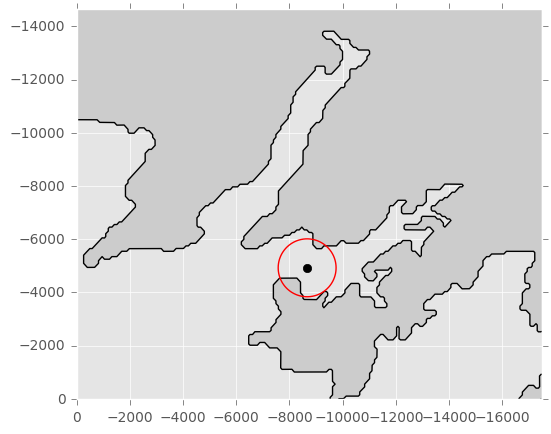

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(6, 6))
m = Basemap(projection='merc',
              urcrnrlat=lat[1], llcrnrlat=lat[2],
              urcrnrlon=lon[1], llcrnrlon=lon[2],
              resolution='f',
              suppress_ticks=False,
              ax=ax)
m.fillcontinents()
m.drawcoastlines()
m.ax = ax
pt = m.plot(core[0], core[1], 'ko', latlon=True)

lons, lats, xs, ys = m.makegrid(200, 200, returnxy=True)

gc = pyproj.Geod(a=m.rmajor, b=m.rminor)

distances = np.zeros(lons.size)

for k, (lo, la) in enumerate(zip(lons.flatten(), lats.flatten())):
    _, _, distances[k] = gc.inv(core[0], core[1], lo, la)
    
distances = distances.reshape(200, 200)  # In km.

# Plot perimeters of equal distance.
levels = [1000]  # [50, 100, 150]
cs = m.contour(xs, ys, distances, levels, colors='r')